# Image augmentation

In this notebook, we will use Keras ImageDataGenerator to generate augmented images to train the model with more data. After generating those new images, I will process them to obtain the bottleneck features and finally train the best model of the last step (NasNet large with 1 final neuron to classify) using all this data.

### Importing the original data 

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

X = np.load('data/processed_data/X_331.npy')
y = np.load('data/processed_data/y.npy')

X.shape                                

(400, 331, 331, 3)

I will first separate the data into train and test set so the augmented will be conducted only on the training set (so the training of the model don't see the test set)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, shuffle=True, stratify=y)
X_train.shape

(340, 331, 331, 3)

### Generating the augmented images

I will generate 2 batch of augmented features, obtaining 680 new images (2 times the original 340 images).

In [14]:
datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='nearest')


# Generating the first batch
augmented_1 = datagen.flow(X_train, y_train, batch_size=340, seed=42)
augmented_x_1, augmented_y_1 = augmented_1[0]

# Generating the second batch
augmented_2 = datagen.flow(X_train, y_train, batch_size=340, seed=23)
augmented_x_2, augmented_y_2 = augmented_2[0]

# Combining the augmented data
augmented_x = np.concatenate((augmented_x_1, augmented_x_2))
augmented_y = np.concatenate((augmented_y_1, augmented_y_1 ))

Just to demonstrate, below are two augmented images:

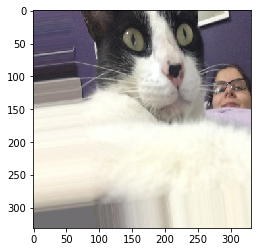

In [119]:
plt.imshow(augmented_x_2[44])

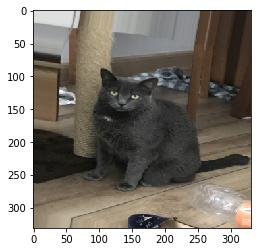

In [122]:
plt.imshow(augmented_x_2[17])

### Obtaining the bottleneck features

In this step, I will combine the original and the augmented training dataset in two arrays: combined_x and combined_y. The combined_x array will pass trough the NasNet network so we can obtain the bottleneck features to use in the next step.

After it, we also pass the X_test to obtain the X_test bottleneck features.

In [18]:
combined_X = np.concatenate((X_train, augmented_x))
combined_y = np.concatenate((y_train, augmented_y))
combined_X.shape

(1020, 331, 331, 3)

In [19]:
from keras.applications.nasnet import NASNetLarge

nasnet = NASNetLarge(include_top=False, weights='imagenet', input_shape=(331,331,3), pooling='avg')
combined_bottleneck = nasnet.predict(combined_X)
combined_bottleneck.shape

(1020, 4032)

In [21]:
np.save('data/bottleneck_features/combined_bottleneck', combined_bottleneck)

In [22]:
test_bottleneck = nasnet.predict(X_test)
test_bottleneck.shape

(60, 4032)

In [23]:
np.save('data/bottleneck_features/test_bottleneck', test_bottleneck)

### Model Implementation

The first model applied is the same model that obtained the best performance on the last step: a NasNET followed by one neuron that predicted the probabilities.

In [24]:
from keras.layers import Dropout, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint  
from keras.backend import clear_session
from tensorflow import set_random_seed
from numpy.random import seed
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [113]:
accuracy = []
epochs = 50

for i in range(5):
    # Split the data into train/validation
    X_train, X_val, y_train, y_val = train_test_split(combined_bottleneck, combined_y, test_size=0.15, 
                                                  random_state=i + 42, shuffle=True, stratify=combined_y)
    
    # Define the model
    model = Sequential()
    model.add(Dense(1, activation='relu', input_shape=(4032,)))
    
    # Set the random seeds
    seed(i + 42)
    set_random_seed(i + 42)
    
    # Compile and train the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    checkpointer = ModelCheckpoint(filepath='models/data_augmentation/weights.best.nasnet_1.hdf5', 
                               verbose=0, save_best_only=True)
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, 
               batch_size=32, callbacks=[checkpointer], verbose=0)
    
    # Calculate the validation accuracy
    val_predictions = (model.predict(X_val) > 0.5) * 1
    val_accuracy = accuracy_score(val_predictions, y_val)
    accuracy.append(val_accuracy)
    print('Model {}, accuracy: {}'.format(i+1, np.round(val_accuracy, 4)))
    
print('The model mean validation accuracy was: {}'.format(np.round(np.mean(accuracy),4)))

# Clear the model for the further models
clear_session()

Model 1, accuracy: 0.5033
Model 2, accuracy: 0.4967
Model 3, accuracy: 0.5098
Model 4, accuracy: 0.4967
Model 5, accuracy: 0.4967
The model mean validation accuracy was: 0.5007


The effect of the augmented data in this model is that the model obtained a small accuracy (just barely above random chance). Instead of finding it's test accuracy, we will try a bigger model (20 neurons and a dropout layer before the final neuron) that could take advantage of the new augmented data.

In [32]:
accuracy = []
epochs = 100

for i in range(5):
    # Split the data into train/validation
    X_train, X_val, y_train, y_val = train_test_split(combined_bottleneck, combined_y, test_size=0.15, 
                                                  random_state=i + 42, shuffle=True, stratify=combined_y)
    
    # Define the model
    model = Sequential()
    model.add(Dense(20, activation='relu', input_shape=(4032,)))
    model.add(Dropout(rate=0.2))
    model.add(Dense(1, activation='relu'))

    # Set the random seeds
    seed(i + 42)
    set_random_seed(i + 42)
    
    # Compile and train the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    checkpointer = ModelCheckpoint(filepath='models/data_augmentation/weights.best.nasnet_2.hdf5', 
                               verbose=0, save_best_only=True)
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, 
               batch_size=32, callbacks=[checkpointer], verbose=0)
    
    # Calculate the validation accuracy
    val_predictions = (model.predict(X_val) > 0.5) * 1
    val_accuracy = accuracy_score(val_predictions, y_val)
    accuracy.append(val_accuracy)
    print('Model {}, accuracy: {}'.format(i+1, np.round(val_accuracy, 4)))
    
print('The model mean validation accuracy was: {}'.format(np.round(np.mean(accuracy),4)))

# Clear the model for the further models
clear_session()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model 1, accuracy: 0.7647
Model 2, accuracy: 0.6928
Model 3, accuracy: 0.7778
Model 4, accuracy: 0.8105
Model 5, accuracy: 0.7974
The model mean validation accuracy was: 0.7686


This model obtained a better accuracy than the last one. The validation accuracy is smaller than the models without augmented data, but we have to consider that is harder to predict the augmented data than the regular data, so one hypothesis is that the test accuracy will be bigger than that (given that the test set doesn't contain augmented images).

Before testing it on the test set, I will test one more model with two fully connected layers before the final layer and find the test accuracy only on the best of the two models.

In [126]:
accuracy = []
epochs = 100

for i in range(5):
    # Split the data into train/validation
    X_train, X_val, y_train, y_val = train_test_split(combined_bottleneck, combined_y, test_size=0.15, 
                                                  random_state=i + 42, shuffle=True, stratify=combined_y)
    
    # Define the model
    model = Sequential()
    model.add(Dense(40, activation='relu', input_shape=(4032,)))
    model.add(Dropout(rate=0.2))
    model.add(Dense(20, activation='relu', input_shape=(4032,)))
    model.add(Dropout(rate=0.2))
    model.add(Dense(1, activation='relu'))

    # Set the random seeds
    seed(i + 42)
    set_random_seed(i + 42)
    
    # Compile and train the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    checkpointer = ModelCheckpoint(filepath='models/data_augmentation/weights.best.nasnet_3.hdf5', 
                               verbose=0, save_best_only=True)
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, 
               batch_size=32, callbacks=[checkpointer], verbose=0)
    
    # Calculate the validation accuracy
    val_predictions = (model.predict(X_val) > 0.5) * 1
    val_accuracy = accuracy_score(val_predictions, y_val)
    accuracy.append(val_accuracy)
    print('Model {}, accuracy: {}'.format(i+1, np.round(val_accuracy, 4)))
    
print('The model mean validation accuracy was: {}'.format(np.round(np.mean(accuracy),4)))

# Clear the model for the further models
clear_session()

Model 1, accuracy: 0.7451
Model 2, accuracy: 0.7516
Model 3, accuracy: 0.7908
Model 4, accuracy: 0.7908
Model 5, accuracy: 0.6144
The model mean validation accuracy was: 0.7386


Running this more complex model obtained a final validation accuracy a bit smaller (0.7386 againts the former 0.7686), so I will use the former model as reference to obtain the test set accuracy.

### Test set accuracy and comparisons

In this section, I will load the weights from the best model (second model) and calculate the test set accuracy. This accuracy will be compared with the benchmark model and the transfer learning model from previous steps.

In [129]:
model = Sequential()
model.add(Dense(20, activation='relu', input_shape=(4032,)))
model.add(Dropout(rate=0.2))
model.add(Dense(1, activation='relu'))

model.load_weights('models/data_augmentation/weights.best.nasnet_2.hdf5')

test_predictions = (model.predict(test_bottleneck) > 0.5) * 1
test_accuracy = accuracy_score(test_predictions, y_test)
print(np.round(test_accuracy,4))

0.95


To recap, the benchmark model was able to obtain an accuracy of 0.617, a small accuracy overall but good considering the small model we could train considering the small dataset we had.

After implementing transfer learning we obtained an accuracy (using the NasNet Large model) of 0.9167, a good improvement from the previous model and a great accuracy overall.

Now, after using augmented features we obtained an even better acurracy, obtaining 0.95 (which means that we had predict wrong only 3 of the 60 available test set images). One funny aspect is that the validation accuracy was 0.7686, which confirmed my hypothesis that the validation accuracy was lower because the augmented images were harder to predict than the original ones.

Finally, below we show the pictures that the model got wrong.

In [130]:
for i in range(60):
    if test_predictions[i] != y_test[i]:
        print(i)
    else:
        pass

10
11
27


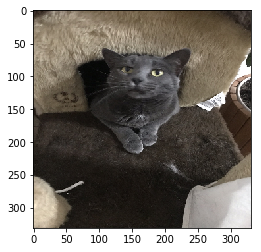

In [139]:
plt.imshow(X_test[10])
plt.show()

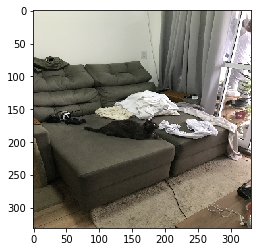

In [140]:
plt.imshow(X_test[11])
plt.show()

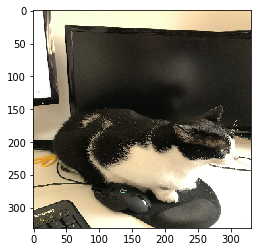

In [141]:
plt.imshow(X_test[27])
plt.show()